# CNN Tutorial

### Introduction

This tutorial will apply the methods learned in the previous tutorial applied to a remote sending example.

As an example we will use the UC Merced dataset ( http://weegee.vision.ucmerced.edu/datasets/landuse.html ). It consists of 21 categories, with 100 images each. The RGB images will be resized to 256 x 256 pixels.

http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

### Load Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from shutil import copyfile
import pickle
import itertools
import torch.utils.data as utils

gpu_on = torch.cuda.is_available()

if not gpu_on:
    print('Training on GPU.')
else:
    print('Training on CPU!')
seed = 4321


Training on CPU!


### Load Dataset

In [2]:
# data source: http://weegee.vision.ucmerced.edu/datasets/landuse.html

category_names = [
 'agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']


# load all data
N_images = 100  # per category
nb_classes = 21
patch_size = 256  # width and height in pixel
channels = 3
nb_images = N_images * nb_classes

# Load the original dataset
data_dir = 'data/UCMerced_LandUse/Images'
images_orig = []
labels_num = []
for i in range(len(category_names)):
    
    # load all images per class
    for j in range(N_images):        
        img_path = os.path.join(data_dir, category_names[i], category_names[i]+'{:02d}.tif'.format(j))
        
        img = Image.open(img_path)
        
        img = img.resize((patch_size, patch_size), Image.ANTIALIAS)
        arr = np.asarray(img)
        images_orig.append(arr)
        labels_num.append([i])

images_orig = np.array(images_orig)
labels_num = np.array(labels_num)

# Save the numpy datasets
np.save('data/UCMerced_images_orig.npy', images_orig)
np.save('data/UCMerced_labels_num.npy', labels_num)

images_orig = np.load('data/UCMerced_images_orig.npy')
labels_num = np.load('data/UCMerced_labels_num.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

labels = to_categorical(labels_num, nb_classes)
print('example of a label with an integer coding: \n{}'.format(labels_num[333]))
print('the same example as a one-hot encoded: vector: \n{}'.format(labels[333]))

print(images_orig.shape, images_orig.dtype)
print(labels.shape, labels.dtype)

example of a label with an integer coding: 
[3]
the same example as a one-hot encoded: vector: 
[[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(2100, 256, 256, 3) uint8
(2100, 1, 21) uint8


### Visualize Dataset

agricultural
(100, 256, 256, 3)


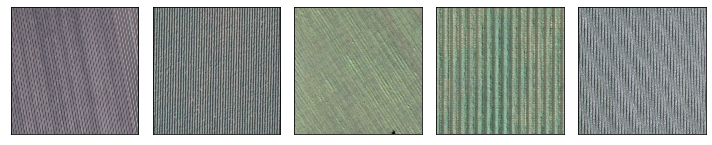

airplane
(100, 256, 256, 3)


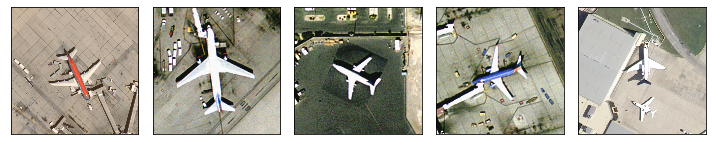

baseballdiamond
(100, 256, 256, 3)


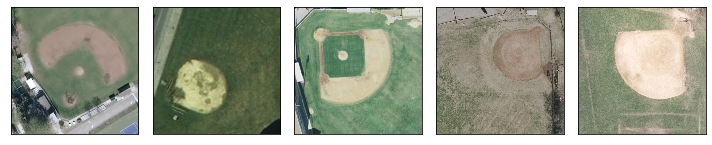

beach
(100, 256, 256, 3)


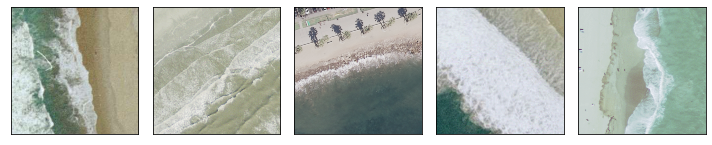

buildings
(100, 256, 256, 3)


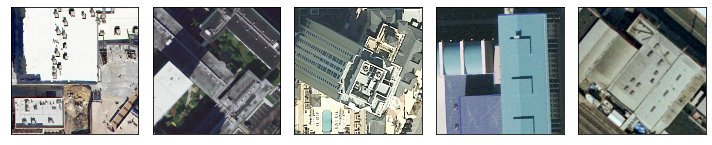

chaparral
(100, 256, 256, 3)


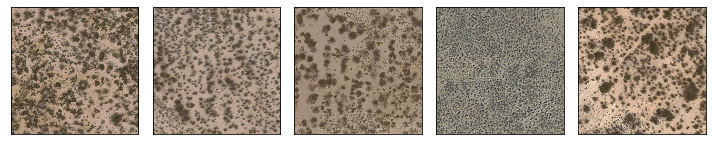

denseresidential
(100, 256, 256, 3)


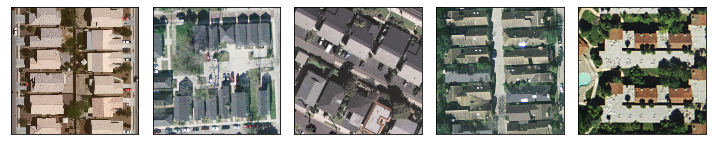

forest
(100, 256, 256, 3)


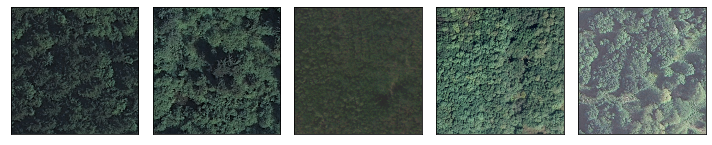

freeway
(100, 256, 256, 3)


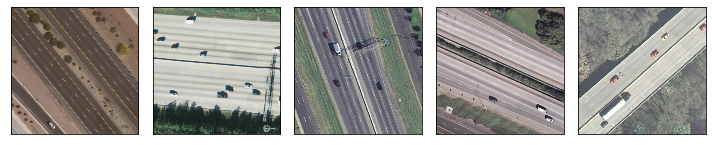

golfcourse
(100, 256, 256, 3)


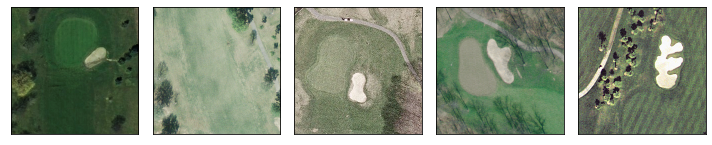

harbor
(100, 256, 256, 3)


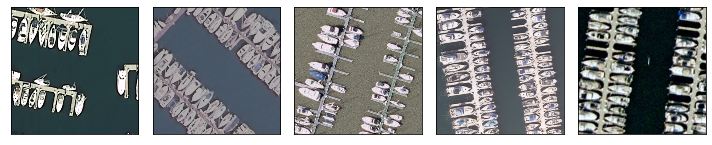

intersection
(100, 256, 256, 3)


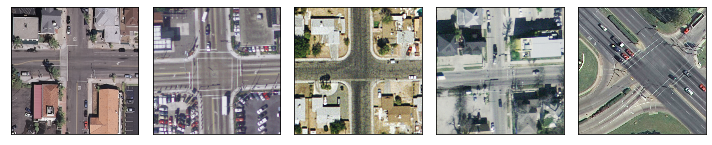

mediumresidential
(100, 256, 256, 3)


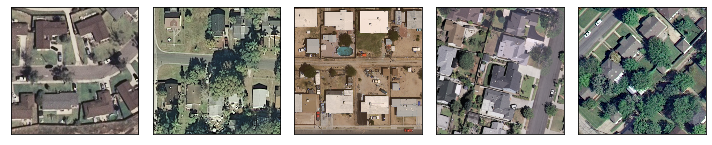

mobilehomepark
(100, 256, 256, 3)


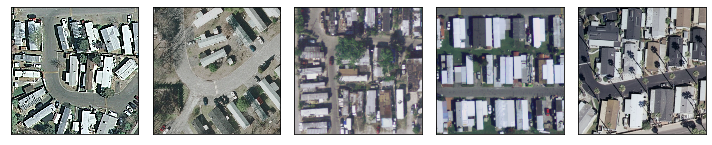

overpass
(100, 256, 256, 3)


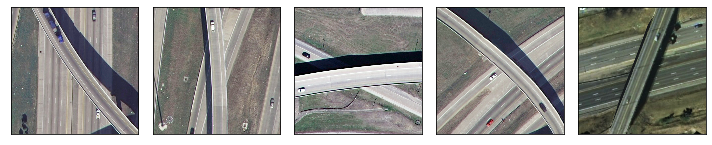

parkinglot
(100, 256, 256, 3)


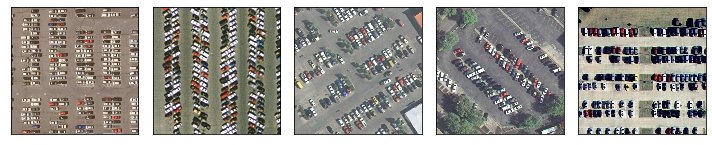

river
(100, 256, 256, 3)


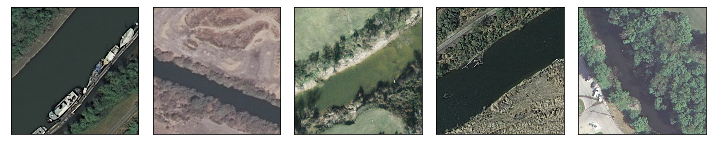

runway
(100, 256, 256, 3)


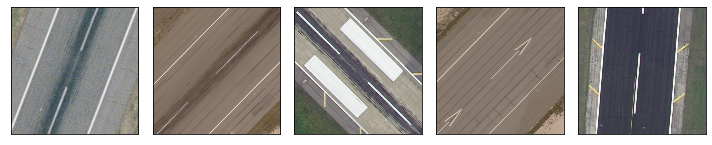

sparseresidential
(100, 256, 256, 3)


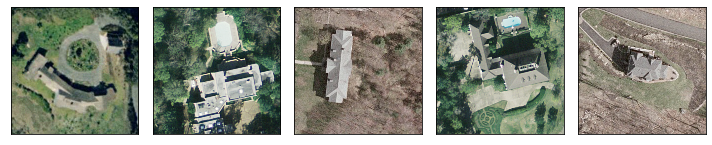

storagetanks
(100, 256, 256, 3)


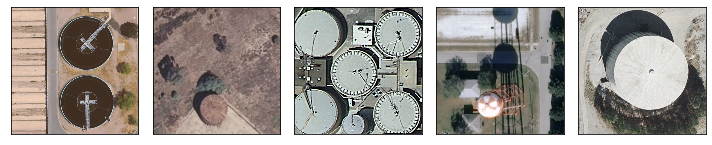

tenniscourt
(100, 256, 256, 3)


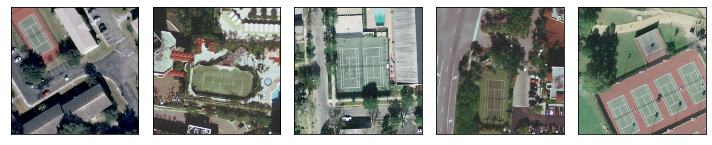

In [3]:
def plotImages( images, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    plt.show()

# Plot some examples for each category    
def plot_examples_per_category():
    for i in range(nb_classes):
        print(category_names[i])
        images_to_print = images_orig[i*N_images:i*N_images+N_images]
        np.random.seed(seed)
        np.random.shuffle(images_to_print)
        print(images_to_print.shape)
        plotImages(images_to_print)

plot_examples_per_category()


### Data Loader

In [75]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, TensorDataset

shuffled_indices = np.arange(nb_images)
np.random.seed(seed)
np.random.shuffle(shuffled_indices)

training_indices = shuffled_indices[:int(0.7*nb_images)]               # 70% for training
val_indices = shuffled_indices[int(0.7*nb_images):int(0.8*nb_images)]  # 10% for val
test_indices = shuffled_indices[int(0.8*nb_images):]                   # 20% for test

training_images = images_orig[training_indices]
val_images = images_orig[val_indices]
test_images = images_orig[test_indices]

training_labels = labels[training_indices]
val_labels = labels[val_indices]
test_labels = labels[test_indices]

train_transforms = transforms.Compose([transforms.Resize(255), 
                                       transforms.CenterCrop(224),  
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = Image.fromarray(x)

        if self.transform:
            x = self.transform(x)
        
        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].shape[0]

batch_size = 20
num_workers = 0

train_dataset_normal = CustomTensorDataset(tensors=(training_images, training_labels), transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset_normal, batch_size=16)

valid_dataset_normal = CustomTensorDataset(tensors=(val_images, val_labels), transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset_normal, batch_size=16)

test_dataset_normal = CustomTensorDataset(tensors=(test_images, test_labels), transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset_normal, batch_size=16)

    
# train_dataset = utils.TensorDataset(torch.Tensor(training_images),torch.Tensor(training_images))
# val_dataset = utils.TensorDataset(torch.Tensor(val_images),torch.Tensor(val_labels))
# val_dataset = utils.TensorDataset(torch.Tensor(test_images),torch.Tensor(test_labels))




# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#     sampler=train_sampler, num_workers=num_workers, shuffle=True)

# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#     num_workers=num_workers)

### Building the network

To build the CNN network that would classify this dataset we would use Convolutional, Maxpooling and then would experiment with using Dropout layers to prevent over fitting. We will start off with a 3 convolutional network, then expand it to an AlexNet-like architecture and compare.

output = int((in_size - kernel_size + 2*(padding)) / stride) + 1


In [76]:
############################################################
import torch
import torch.nn as nn

class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

model = CNN()
model.cuda()


CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace)
   

### Define Loss Function and Optimizer

In [77]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


### Train and Validate Network

In [78]:
# Change this every experiment
exp_name = "unproc_small_cnn"

# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    history_updater(exp_name, history_plot, train_loss, valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model_cifar_'+exp_name+'.pt')
        valid_loss_min = valid_loss


RuntimeError: size mismatch, m1: [16 x 262144], m2: [4096 x 1024] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:268

In [ ]:
model.load_state_dict(torch.load('best_model_cifar_'+exp_name+'.pt'))

### Test Model

In [65]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu_on else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


RuntimeError: size mismatch, m1: [16 x 262144], m2: [4096 x 1024] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:268

### Prediction

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images.numpy()

# move model inputs to cuda, if GPU available
images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not gpu_on else np.squeeze(preds_tensor.cpu().numpy())
 
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("P:{} - GT:({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))


### Plot Loss

In [ ]:
epochs_axis = [*range(n_epochs)]

acc_legend = []
for key in history_plot:
    plt.plot(epochs_axis, history_plot[key][0])
    plt.plot(epochs_axis, history_plot[key][1])
    acc_legend += ['train_'+key, 'val_'+key]

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(acc_legend, loc='lower right')
plt.show()


### How can we improve the model, what are the weakenesses?